
#  FarmTech Solutions
**Integrantes**: Pedro Henrique Zani (RM 564956) e Flavia Nunes Bocchino (RM 564213)


**Arquivo:** PedroHenriqueZani_rm-564956_and_FlaviaNunesBocchino_rm-564213_pbl_fase4.ipynb


### Como usar
Execute célula por célula, na ordem. Se der erro de caminho, confira a pasta `data/`.

In [15]:
# ============== Setup Rápido ==============
import warnings; warnings.filterwarnings("ignore")
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, IsolationForest
from sklearn.svm import SVR

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

import joblib, os

# Localiza dataset
DATA = Path(r"c:\Users\pedro\Downloads\farmtech_solutions_simple\data\crop_yield.csv")
assert DATA.exists(), "Arquivo data/crop_yield.csv não encontrado. Coloque o CSV em data/."
print("Dataset:", DATA)

# Carrega e padroniza colunas para PT-BR
df = pd.read_csv(DATA).rename(columns={
    "Crop": "Cultura",
    "Precipitation (mm day-1)": "Precipitacao_mm_dia",
    "Specific Humidity at 2 Meters (g/kg)": "Umidade_especifica_gkg",
    "Relative Humidity at 2 Meters (%)": "Umidade_relativa_pct",
    "Temperature at 2 Meters (C)": "Temperatura_2m_C",
    "Yield": "Rendimento_t_ha",
})
req = ["Cultura","Precipitacao_mm_dia","Umidade_especifica_gkg","Umidade_relativa_pct","Temperatura_2m_C","Rendimento_t_ha"]
missing = [c for c in req if c not in df.columns]
assert not missing, f"Colunas faltando no CSV: {missing}"
print(df.shape); df.head()

Dataset: c:\Users\pedro\Downloads\farmtech_solutions_simple\data\crop_yield.csv
(156, 6)


,Cultura,Precipitacao_mm_dia,Umidade_especifica_gkg,Umidade_relativa_pct,Temperatura_2m_C,Rendimento_t_ha
0,"Cocoa, beans",2248.92,17.72,83.40,26.01,11560
1,"Cocoa, beans",1938.42,17.54,82.11,26.11,11253
2,"Cocoa, beans",2301.54,17.81,82.79,26.24,9456
3,"Cocoa, beans",2592.35,17.61,85.07,25.56,9321
4,"Cocoa, beans",2344.72,17.61,84.12,25.76,8800


## 1) EDA

Faltantes:
 Cultura                   0
Precipitacao_mm_dia       0
Umidade_especifica_gkg    0
Umidade_relativa_pct      0
Temperatura_2m_C          0
Rendimento_t_ha           0
dtype: int64
Duplicados: 0

Correlação:
                         Precipitacao_mm_dia  Umidade_especifica_gkg  \
Precipitacao_mm_dia                   1.000                   0.488   
Umidade_especifica_gkg                0.488                   1.000   
Umidade_relativa_pct                  0.749                   0.437   
Temperatura_2m_C                     -0.084                   0.699   
Rendimento_t_ha                       0.019                   0.013   

                        Umidade_relativa_pct  Temperatura_2m_C  \
Precipitacao_mm_dia                    0.749            -0.084   
Umidade_especifica_gkg                 0.437             0.699   
Umidade_relativa_pct                   1.000            -0.337   
Temperatura_2m_C                      -0.337             1.000   
Rendimento_t_ha       

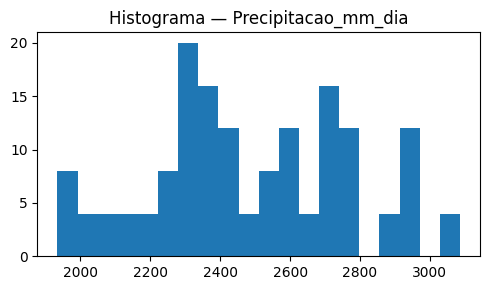

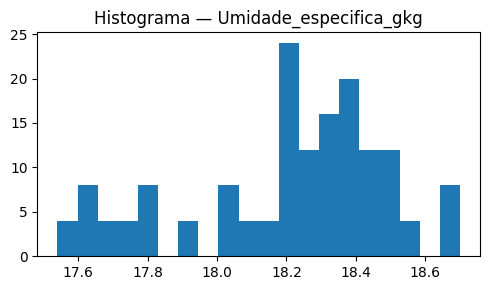

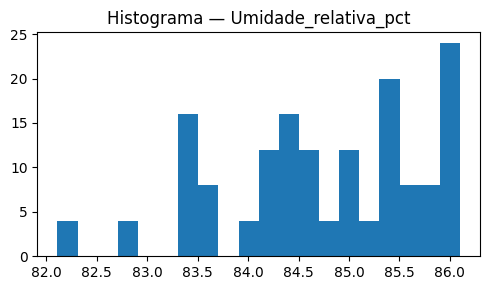

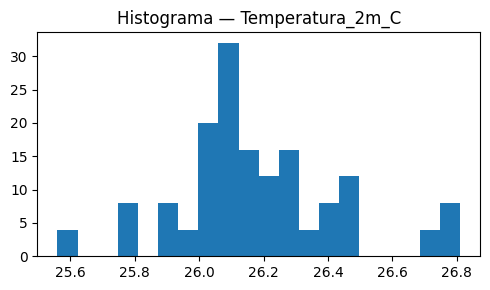

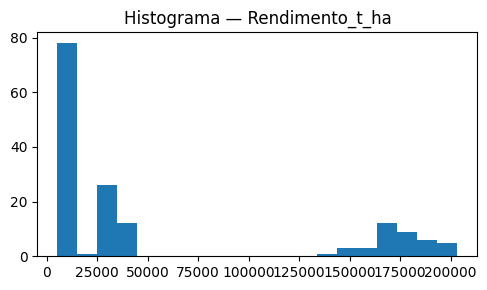

In [18]:

# ============== 1) EDA Enxuto ==============
print("Faltantes:\n", df.isna().sum())
print("Duplicados:", df.duplicated().sum())

num_cols = ["Precipitacao_mm_dia","Umidade_especifica_gkg","Umidade_relativa_pct","Temperatura_2m_C","Rendimento_t_ha"]
corr = df[num_cols].corr()
print("\nCorrelação:\n", corr.round(3))

# Histogramas rápidos
for col in num_cols:
    plt.figure(figsize=(5,3))
    plt.hist(df[col].dropna(), bins=20)
    plt.title(f"Histograma — {col}")
    plt.tight_layout()
    plt.show()


## 2) Outliers

Outliers (IQR) no Rendimento: 35


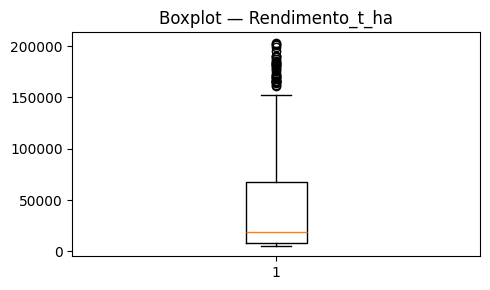

Outliers (IsolationForest): 63


In [19]:

# ============== 2) Outliers Simples ==============
# IQR no alvo
q1, q3 = df["Rendimento_t_ha"].quantile(0.25), df["Rendimento_t_ha"].quantile(0.75)
iqr = q3 - q1
low, up = q1 - 1.5*iqr, q3 + 1.5*iqr
print("Outliers (IQR) no Rendimento:", int(((df["Rendimento_t_ha"]<low)|(df["Rendimento_t_ha"]>up)).sum()))

plt.figure(figsize=(5,3))
plt.boxplot(df["Rendimento_t_ha"].dropna(), vert=True)
plt.title("Boxplot — Rendimento_t_ha")
plt.tight_layout()
plt.show()

# IsolationForest (multivariado) — leve
num_cols = ["Precipitacao_mm_dia","Umidade_especifica_gkg","Umidade_relativa_pct","Temperatura_2m_C","Rendimento_t_ha"]
iso = IsolationForest(random_state=42, n_estimators=100)
pred_iso = iso.fit_predict(df[num_cols].dropna())
print("Outliers (IsolationForest):", int((pred_iso==-1).sum()))


## 3) Clusterização (KMeans + PCA)

Melhor K: 4 | silhouette: 0.4397


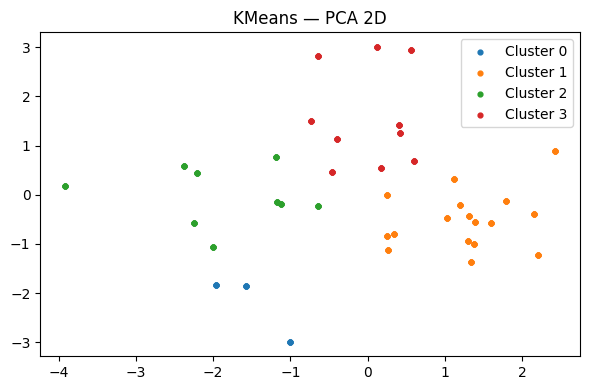

,Precipitacao_mm_dia,Umidade_especifica_gkg,Umidade_relativa_pct,Temperatura_2m_C
cluster,,,,
0,2425.46,17.64,84.58,25.69
1,2733.52,18.34,85.65,26.12
2,2141.95,17.90,83.75,26.12
3,2394.97,18.41,84.12,26.50


In [20]:

# ============== 3) Clusterização (KMeans) ==============
from sklearn.preprocessing import StandardScaler
features = ["Precipitacao_mm_dia","Umidade_especifica_gkg","Umidade_relativa_pct","Temperatura_2m_C"]
Xc = df[features].dropna()
Xsc = StandardScaler().fit_transform(Xc)

best_k, best_s = None, -1
for k in [2,3,4]:
    lab = KMeans(n_clusters=k, random_state=42, n_init=10).fit_predict(Xsc)
    s = silhouette_score(Xsc, lab)
    if s > best_s: best_s, best_k = s, k
print("Melhor K:", best_k, "| silhouette:", round(best_s,4))

lab = KMeans(n_clusters=best_k, random_state=42, n_init=10).fit_predict(Xsc)
pca = PCA(n_components=2, random_state=42).fit_transform(Xsc)

plt.figure(figsize=(6,4))
for L in range(best_k):
    m = lab==L
    plt.scatter(pca[m,0], pca[m,1], s=12, label=f"Cluster {L}")
plt.legend(); plt.title("KMeans — PCA 2D"); plt.tight_layout(); plt.show()

cluster_df = pd.DataFrame(Xc, columns=features).copy()
cluster_df["cluster"] = lab
cluster_df.groupby("cluster")[features].mean().round(2)


## 4) Regressão (5 modelos)

In [21]:
# ============== 4) Regressão (5 modelos) ==============
X = df[["Cultura","Precipitacao_mm_dia","Umidade_especifica_gkg","Umidade_relativa_pct","Temperatura_2m_C"]].dropna()
y = df.loc[X.index, "Rendimento_t_ha"]

cat, num = ["Cultura"], ["Precipitacao_mm_dia","Umidade_especifica_gkg","Umidade_relativa_pct","Temperatura_2m_C"]
cat_tf = OneHotEncoder(handle_unknown="ignore")
num_tf = StandardScaler()

def pipe(model, scale_num=True):
    pre = ColumnTransformer([("num", num_tf if scale_num else "passthrough", num),
                             ("cat", cat_tf, cat)])
    return Pipeline([("pre", pre), ("model", model)])

models = {
  "LinearRegression": pipe(LinearRegression(), True),
  "Ridge": pipe(Ridge(alpha=1.0, random_state=42), True),
  "RandomForest": pipe(RandomForestRegressor(n_estimators=100, random_state=42), False),
  "GradientBoosting": pipe(GradientBoostingRegressor(random_state=42), True),
  "SVR_RBF": pipe(SVR(kernel="rbf", C=10.0, epsilon=0.2), True),
}

cv = KFold(n_splits=3, shuffle=True, random_state=42)
rows=[]
for name, p in models.items():
    rmse = -cross_val_score(p, X, y, scoring="neg_root_mean_squared_error", cv=cv)
    r2 = cross_val_score(p, X, y, scoring="r2", cv=cv)
    rows.append({"modelo":name,"rmse_media":rmse.mean(),"r2_medio":r2.mean()})
cv_df = pd.DataFrame(rows).sort_values("rmse_media")
print(cv_df)

best = cv_df.iloc[0]["modelo"]; best_pipe = models[best]
Xtr,Xte,ytr,yte = train_test_split(X,y,test_size=0.2,random_state=42)
best_pipe.fit(Xtr,ytr); pred = best_pipe.predict(Xte)
rmse = np.sqrt(mean_squared_error(yte, pred))  # Calculate RMSE manually
mae = mean_absolute_error(yte, pred)
r2 = r2_score(yte, pred)
print(f"Teste — {best}: RMSE={rmse:.3f} | MAE={mae:.3f} | R²={r2:.3f}")

# Salva o melhor modelo (opcional)
os.makedirs("models", exist_ok=True)
joblib.dump(best_pipe, "models/best_model.pkl")

             modelo    rmse_media  r2_medio
3  GradientBoosting   7704.501450  0.987687
2      RandomForest   7707.715207  0.987599
0  LinearRegression   7998.039866  0.986960
1             Ridge   8441.388674  0.985404
4           SVR_RBF  79437.624104 -0.289411
Teste — GradientBoosting: RMSE=6061.761 | MAE=3066.408 | R²=0.991


['models/best_model.pkl']